In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import seaborn as sns

In [155]:
%config IPCompleter.greedy=True

In [156]:
class MLP_new:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len,
                 acti_funs,acti_funs_grad,cost_fun,cost_fun_grad,seed=123, problem=""):
        
        np.random.seed(seed)
        
        self.acti_funs=acti_funs
        self.acti_funs_grad=acti_funs_grad
        
        self.cost_fun=cost_fun
        self.cost_fun_grad=cost_fun_grad
        
        if problem=="classification" or problem=="C":
            self.acti_funs=self.acti_funs+[softmax]
            self.acti_funs_grad=self.acti_funs_grad+[softmax_grad]
            
        if problem=="regression" or problem=="R":
            self.acti_funs=self.acti_funs+[identity]
            self.acti_funs_grad=self.acti_funs_grad+[identity_grad]
            
        
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.output_before =np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.acti_funs[i](self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.acti_funs[i](self.weights[i].dot(input_layer)+self.biases[i])
                
        
       
        output_layer=self.acti_funs[-1](self.weights[-1].dot(input_layer)+self.biases[-1])
        self.output_before=(self.weights[-1].dot(input_layer)+self.biases[-1]).T
        self.output_layer=output_layer.T
        
        return(output_layer.T)
        
    def train(self,train_input_layer,train_output_layer,max_epoch=2000,rate=0.1,beta=0,batch=1,stop=10**-6,RMSprop=False,L1=False,L2=False,eps=10**-8,alpha=0.01,
              validate=False,early_stop=3,test_input_layer=0,test_output_layer=0,return_error_list=True,return_gradients=False,Verbose=True):
    
        #creating batches
        lin=np.linspace(0,train_input_layer.shape[0],int(1/batch)+1).round().astype(int)
        #initiating errors
        output_layer=self.calculate(train_input_layer)
        error=self.cost_fun(train_output_layer,output_layer)
        #initiating early stopping
        warning=0
        if validate:
            output_layer=self.calculate(test_input_layer)
            error_test=self.cost_fun(test_output_layer,output_layer)
        
        print("start error "+str(error))
        #initiating old gradient list
        old_grad=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_grad_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]
        
        
        for epoch in range(1,max_epoch+1):
            
            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]
                
                #backpropagate errors
                for x in range(batch_size):
                    #all cost funs should be independent from size of vectors because we rescale them later
                    #last acti fun is used at output_layer so for classification it should be softmax and for regresion identity
                    errors[x][-1]=((self.cost_fun_grad(train_output_layer[lin[b]:lin[b+1]][x:x+1],output_layer[x:x+1]))*self.acti_funs_grad[-1](self.output_before[x:x+1])).T
                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*self.acti_funs_grad[i](self.hidden_layers[i][:,x:x+1])
                
                #calculate gradients
                for l in range(1,len(self.weights)):
                    #we rescale by batch size here
                    #new_grad=np.clip(new_grad,-10**6,10**6) is used to prevent weights exploding
                    #we update grads beta here is momentum
                    if(RMSprop):
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        #regularization
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        #updating gradients
                        old_grad[l][b]=beta*old_grad[l][b]+(1-beta)*new_grad**2
                        self.weights[l]=self.weights[l]-new_grad*(rate/(np.sqrt(old_grad[l][b])+eps))

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        old_grad_bias[l][b]=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias**2
                        self.biases[l]=self.biases[l]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[l][b])+eps))
                    else:
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        new_grad=beta*old_grad[l][b]+(1-beta)*new_grad
                        old_grad[l][b]=new_grad
                        self.weights[l]=self.weights[l]-new_grad*rate

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                        new_grad_bias=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias
                        old_grad_bias[l][b]=new_grad_bias
                        self.biases[l]=self.biases[l]-new_grad_bias*rate
                
                #calculate gradient for input layer
                if(RMSprop):
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    old_grad[0][b]=beta*old_grad[0][b]+(1-beta)*new_grad**2
                    self.weights[0]=self.weights[0]-new_grad*(rate/(np.sqrt(old_grad[0][b])+eps))

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    old_grad_bias[0][b]=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias**2
                    self.biases[0]=self.biases[0]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[0][b])+eps))
                else:
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    new_grad=beta*old_grad[0][b]+(1-beta)*new_grad
                    old_grad[0][b]=new_grad
                    self.weights[0]=self.weights[0]-new_grad*rate

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    new_grad_bias=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias
                    old_grad_bias[0][b]=new_grad_bias
                    self.biases[0]=self.biases[0]-new_grad_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=self.cost_fun(train_output_layer,output_layer)
            
            #check stopping conditions if worse early_stop a row then stop
            if validate:
                output_layer=self.calculate(test_input_layer)
                new_error_test=self.cost_fun(test_output_layer,output_layer)
                if new_error_test>error_test:
                    if warning>=early_stop:
                        break
                    else:
                        error_test=new_error_test
                        warning+=1
                else:
                    error_test=new_error_test
                    warning=0
                
            if return_error_list:
                error_list.append(new_error)
            
            if(epoch % 500 == 0 and Verbose):
                print("epoch "+str(epoch))
                
            if new_error<=0:
                break
            
            if ((abs(new_error-error)/error)<stop).all():
                break

            error=new_error
        
        print("end in epoch "+str(epoch)+ " with error "+str(new_error))
        if return_error_list:
            return error_list
        elif return_gradients:
            return old_grad, old_grad_bias
        else:
            return new_error

In [157]:
def softmax(z):
    e = np.exp(z)
    return e / np.sum(e, axis=0,keepdims=True)

In [158]:
def softmax_grad(s):
    s=softmax(s.T)
    return (s*(1-s)).T   

In [159]:
def ReLU(x):
    return x * (x > 0)

In [160]:
def ReLU_grad(x):
    return 1. * (x > 0)

In [161]:
def tanh(z):
    e = np.exp(2*z)
    return 1-2/(e+1)

In [162]:
def tanh_grad(z):
    return 1-tanh(z)**2

In [163]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

In [164]:
def MSE_grad(Y,Y_hat):
     return Y_hat-Y

In [165]:
def MAE(Y,Y_hat):
    return np.sum(np.abs(Y-Y_hat))

In [166]:
def MAE_grad(Y,Y_hat):
    return (Y_hat>=Y)*2-1

In [167]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [168]:
def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [169]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = abs(np.sum(targets*np.log(predictions)))
    return ce


In [170]:
def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [171]:
def identity(x):
    return x

In [172]:
def identity_grad(x):
    return 1

In [173]:
df=pd.DataFrame(columns=["model_n","problem","dataset","columns_input","columns_output",
                  "rows_train","rows_test","layers","neurons","connections",
                  "L1","L2","regularization","alpha","activation_function",
                         "validate","accuracy_train","accuracy_test","score_train","score_test","cost_function",
                         "epochs","time","rate","beta","RMSprop","batch"])

MAX_EPOCH=300

networks=[]

networks_names=[]

networks_err=[]

np.random.seed(123)

model_n=0

In [174]:
def Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,dataset,input_layer_len, output_layer_len, L,
                 acti_funs,acti_funs_str,acti_funs_grad,cost_fun,cost_fun_str,cost_fun_grad,networks,networks_err,problem=""):
    
    global MAX_EPOCH
    mlp_test=MLP_new(input_layer_len,output_layer_len,L,[acti_funs]*len(L),[acti_funs_grad]*len(L),cost_fun,cost_fun_grad,problem=problem)
        
    start_time = time.time()
    er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=MAX_EPOCH,Verbose=False)
    end_time = time.time()
    t=end_time - start_time
        
    networks.append(deepcopy(mlp_test))
    networks_err.append(er.copy())
    networks_names.append(dataset+str(L))
    
    output_layer=mlp_test.calculate(train_input_layer)
    score_train=cost_fun(train_output_layer,output_layer)/output_layer.shape[0]
    if problem=="classification":
        accuracy_train=round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)
    else:
        accuracy_train=0
    output_layer=mlp_test.calculate(test_input_layer)
    score_test=cost_fun(test_output_layer,output_layer)/output_layer.shape[0]
    if problem=="classification":
        accuracy_test=round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)
    else:
        accuracy_test=0
    
    L1=sum([np.sum(w**2) for w in mlp_test.weights])
    L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
    
    rows_train=train_input_layer.shape[0]
    rows_test=test_input_layer.shape[0]
    columns_input=train_input_layer.shape[1]
    columns_output=train_output_layer.shape[1]
    connections=sum([L[i]*L[i+1] for i in range(len(L)-1)])+columns_input*L[0]+columns_output*L[-1]
    neurons=sum(L)
    L1=L1/connections
    L2=L2/connections
    global model_n
    model_n+=1
    t=t/(len(er)-1)
    df=df.append({"model_n":model_n,"problem":problem,"dataset":dataset,"columns_input":columns_input,"columns_output":columns_output,
                  "rows_train":rows_train,"rows_test":rows_test,"layers":len(L),"neurons":neurons,"connections":connections,
                  "L1":L1,"L2":L2,"regularization":"None","alpha":0,"activation_function":acti_funs_str,
                         "validate":0,"accuracy_train":accuracy_train,"accuracy_test":accuracy_test,"score_train":score_train,"score_test":score_test,"cost_function":cost_fun_str,
                         "epochs":len(er)-1,"time":t,"rate":0.1,"beta":0,"RMSprop":False,"batch":1},ignore_index=True)
    return df

# Classification

# Simple

In [175]:
test = np.loadtxt("Project 1 datasets/classification/data.simple.train.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [176]:
test = np.loadtxt("Project 1 datasets/classification/data.simple.test.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

## visualize

[Text(0.5, 1.0, 'Test data')]

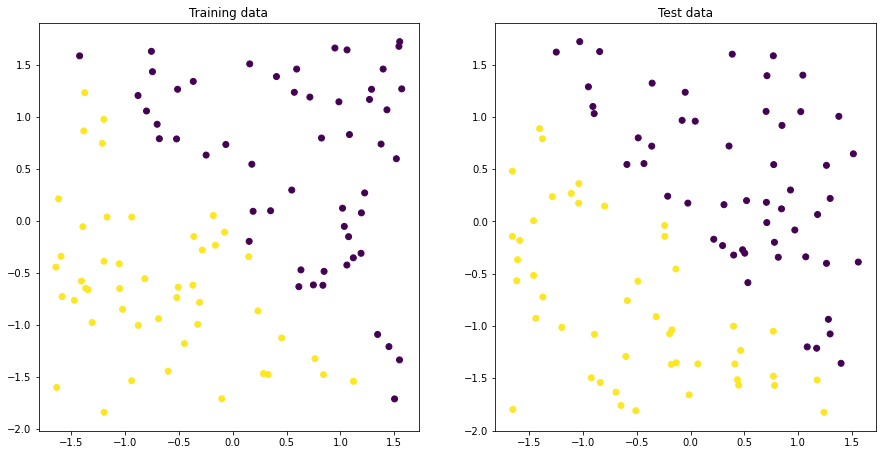

In [177]:
fig=plt.figure(figsize=(15,7.5))
ax=fig.add_subplot(121)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Training data")

ax1=fig.add_subplot(122)
ax1.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax1.set(title="Test data")

# Calculate everything

In [178]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"simple",2,2,L,sigmoid,"sigmoid",sigmoid_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"simple",2,2,L,ReLU,"ReLU",ReLU_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"simple",2,2,L,tanh,"tanh",tanh_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"simple",2,2,L,sigmoid,"sigmoid",sigmoid_grad,cross_entropy,"cross entropy",cross_entropy_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"simple",2,2,L,ReLU,"ReLU",ReLU_grad,cross_entropy,"cross entropy",cross_entropy_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"simple",2,2,L,tanh,"tanh",tanh_grad,cross_entropy,"cross entropy",cross_entropy_grad,networks,networks_err,problem="classification")

start error 62.92620267142532
end in epoch 300 with error 31.620840956881118
start error 79.42840929510513
end in epoch 300 with error 11.543737062467333
start error 91.26986610243935
end in epoch 300 with error 9.435332089021129
start error 82.59923150557671
end in epoch 300 with error 17.466290786305834
start error 102.69847753754065
end in epoch 300 with error 5.757639573458691
start error 117.85718367495308
end in epoch 300 with error 5.876641913883379
start error 57.357348781268676
end in epoch 300 with error 45.854325102559585
start error 50.067390680507714
end in epoch 300 with error 9.537067040376737
start error 54.0860514380615
end in epoch 300 with error 5.557920943125991
start error 77.63926739913273
end in epoch 300 with error 37.37159953384293
start error 69.31543717814816
end in epoch 300 with error 3.1161642961539795
start error 73.67297955949562
end in epoch 300 with error 2.8282899512019952
start error 42.94307756542504
end in epoch 300 with error 18.53092783283292
sta

[Text(0.5, 1.0, 'Test data')]

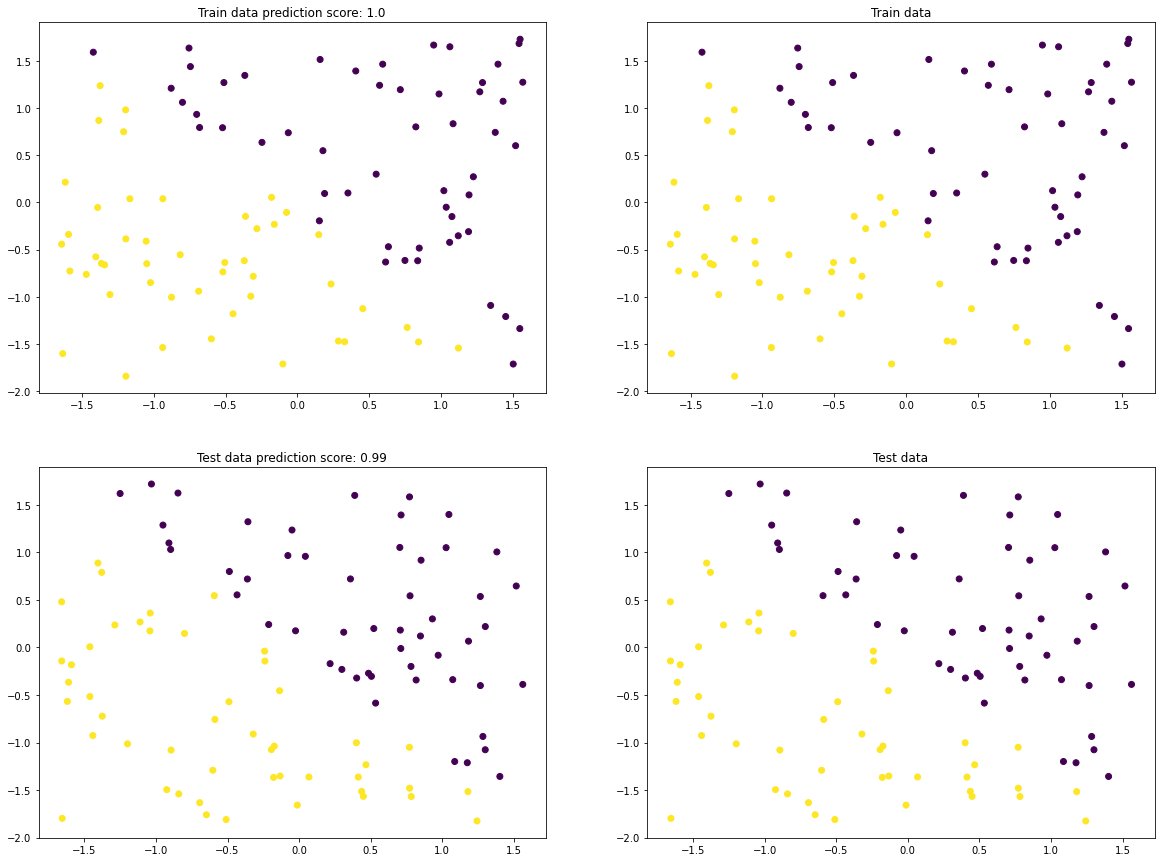

In [179]:
best=df[df["dataset"]=="simple"][-36:].nsmallest(1, 'score_test')["model_n"].values[0]
mlp_test=networks[best-1]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(221)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax1=fig.add_subplot(222)
ax1.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax1.set(title="Train data")


output_layer=mlp_test.calculate(test_input_layer)

ax2=fig.add_subplot(223)
ax2.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax2.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax3=fig.add_subplot(224)
ax3.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax3.set(title="Test data")

# Three_gauss

In [180]:
test = np.loadtxt("Project 1 datasets/classification/data.three_gauss.train.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [181]:
test = np.loadtxt("Project 1 datasets/classification/data.three_gauss.test.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

## visualize

[Text(0.5, 1.0, 'Test data')]

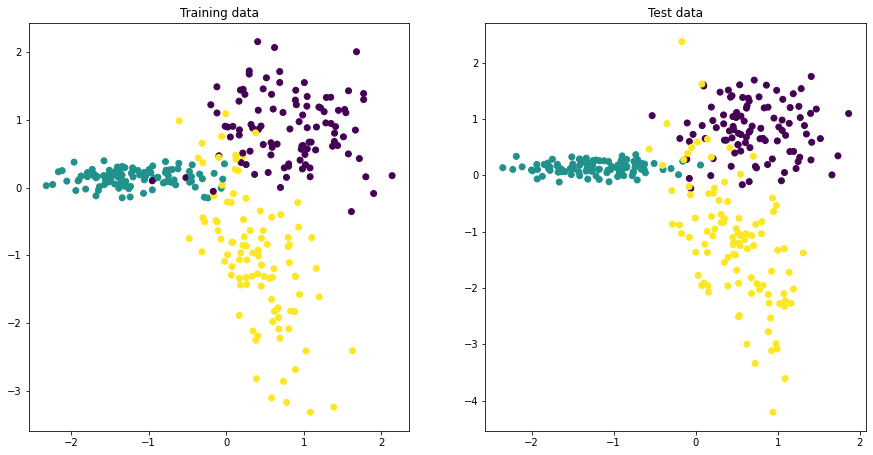

In [182]:
fig=plt.figure(figsize=(15,7.5))
ax=fig.add_subplot(121)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Training data")

ax1=fig.add_subplot(122)
ax1.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax1.set(title="Test data")

# Calculate everything

In [183]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"three_gauss",2,3,L,sigmoid,"sigmoid",sigmoid_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"three_gauss",2,3,L,ReLU,"ReLU",ReLU_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"three_gauss",2,3,L,tanh,"tanh",tanh_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"three_gauss",2,3,L,sigmoid,"sigmoid",sigmoid_grad,cross_entropy,"cross entropy",cross_entropy_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"three_gauss",2,3,L,ReLU,"ReLU",ReLU_grad,cross_entropy,"cross entropy",cross_entropy_grad,networks,networks_err,problem="classification")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"three_gauss",2,3,L,tanh,"tanh",tanh_grad,cross_entropy,"cross entropy",cross_entropy_grad,networks,networks_err,problem="classification")

start error 262.3042079162792
end in epoch 300 with error 175.8286153870264
start error 257.26998656180035
end in epoch 300 with error 127.87328502514139
start error 276.48425553389177
end in epoch 300 with error 49.28550070493735
start error 439.2417735523351
end in epoch 300 with error 127.92410520829134
start error 457.74590218441483
end in epoch 300 with error 69.79576050078676
start error 455.1614576994701
end in epoch 300 with error 69.14728834783618
start error 211.44220855707482
end in epoch 300 with error 188.92275902534266
start error 198.9740090488133
end in epoch 300 with error 78.8365113615801
start error 170.68091554663803
end in epoch 300 with error 49.469966979065696
start error 350.4062107842304
end in epoch 300 with error 233.9177247436341
start error 327.0653861512518
end in epoch 300 with error 53.253273180636725
start error 285.9814740537047
end in epoch 300 with error 68.91483593553943
start error 179.8218700133911
end in epoch 300 with error 92.92407941415111
sta

[Text(0.5, 1.0, 'Test data')]

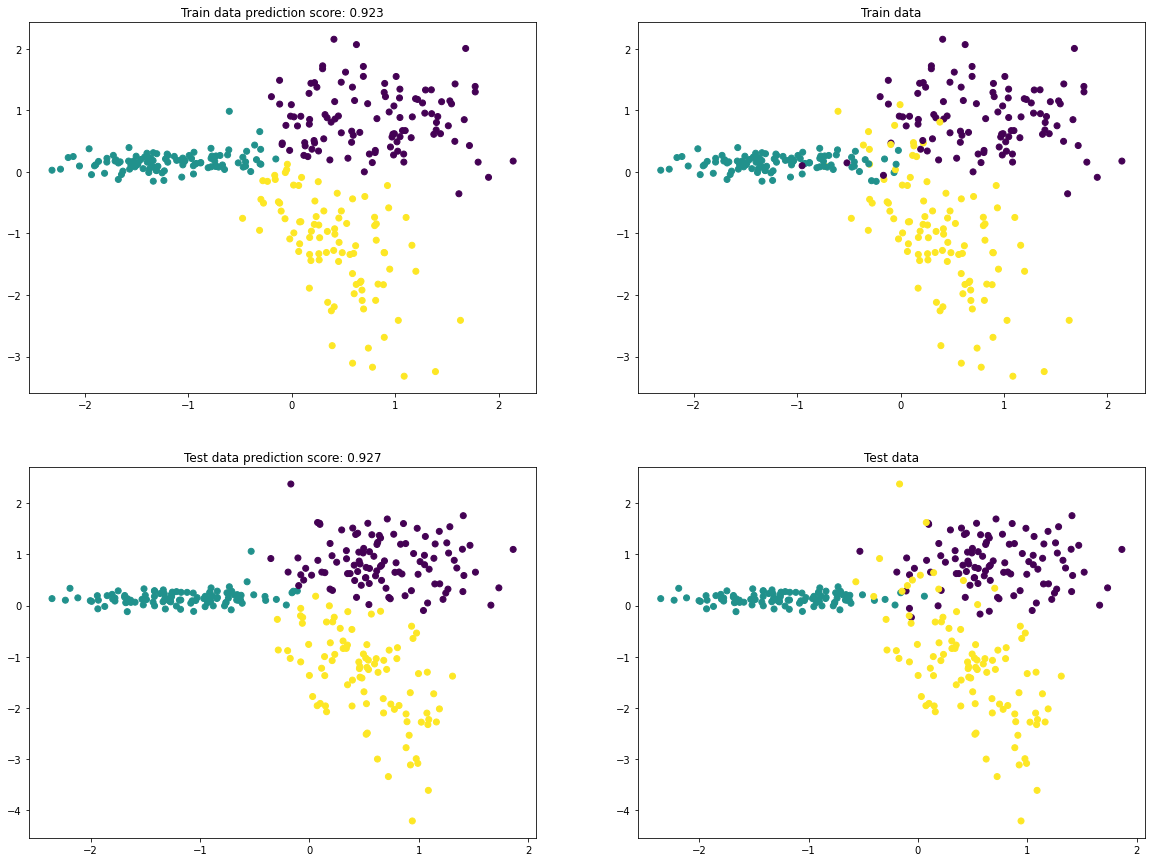

In [184]:
best=df[df["dataset"]=="three_gauss"][-36:].nsmallest(1, 'score_test')["model_n"].values[0]
mlp_test=networks[best-1]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(221)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax1=fig.add_subplot(222)
ax1.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax1.set(title="Train data")


output_layer=mlp_test.calculate(test_input_layer)

ax2=fig.add_subplot(223)
ax2.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax2.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax3=fig.add_subplot(224)
ax3.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax3.set(title="Test data")

# Regression

# Activation

In [185]:
test = np.loadtxt("Project 1 datasets/regression/data.activation.train.100.csv", delimiter=',', skiprows=1, usecols=range(0,2))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=(Y-np.mean(Y,axis=0))/np.std(Y,axis=0)

In [186]:
test = np.loadtxt("Project 1 datasets/regression/data.activation.test.100.csv", delimiter=',', skiprows=1, usecols=range(0,2))
X1=test[:,0:1]
Y1=test[:,1:2]
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=(Y1-np.mean(Y,axis=0))/np.std(Y,axis=0)

## visualize

[Text(0.5, 1.0, 'Test Set')]

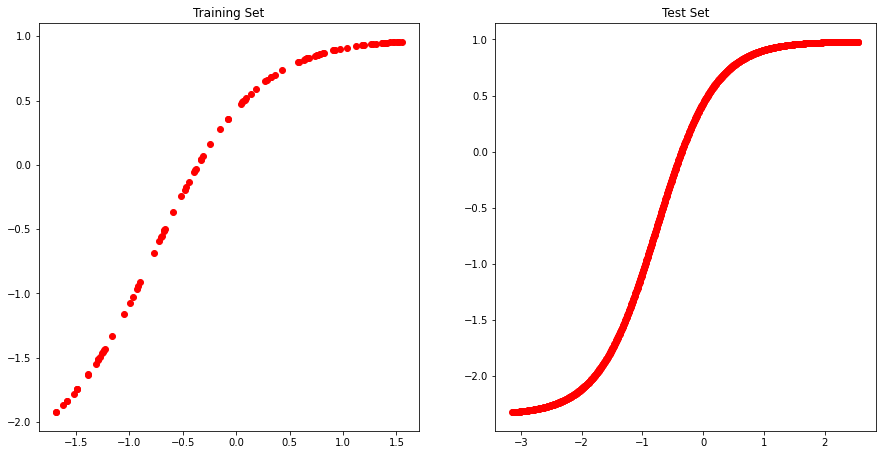

In [187]:
fig=plt.figure(figsize=(15,7.5))
ax1=fig.add_subplot(121)
ax1.scatter(train_input_layer, train_output_layer, color='r')
ax1.set(title="Training Set")
ax2=fig.add_subplot(122)
ax2.scatter(test_input_layer, test_output_layer, color='r')
ax2.set(title="Test Set")

# Calculate everything

In [188]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"activation",1,1,L,sigmoid,"sigmoid",sigmoid_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"activation",1,1,L,ReLU,"ReLU",ReLU_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"activation",1,1,L,tanh,"tanh",tanh_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"activation",1,1,L,sigmoid,"sigmoid",sigmoid_grad,MAE,"MAE",MAE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"activation",1,1,L,ReLU,"ReLU",ReLU_grad,MAE,"MAE",MAE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"activation",1,1,L,tanh,"tanh",tanh_grad,MAE,"MAE",MAE_grad,networks,networks_err,problem="regression")

start error 160.63479248715925
end in epoch 300 with error 6.143590155984298
start error 201.76598716249592
end in epoch 300 with error 0.27992696319462995
start error 280.68518597056936
end in epoch 300 with error 0.7233510988471252
start error 100.30418555987332
end in epoch 300 with error 9.718166471952381
start error 121.1924383323545
end in epoch 300 with error 12.730777908456094
start error 149.14547196992498
end in epoch 300 with error 4.703742584324585
start error 138.79404704250695
end in epoch 300 with error 4.7540314491041595
start error 58.23736941080379
end in epoch 300 with error 0.19616874310785798
start error 41.44010166180425
end in epoch 300 with error 0.03463504309425296
start error 107.83353121069301
end in epoch 300 with error 16.950340037512518
start error 69.66911369617533
end in epoch 300 with error 9.90003013537809
start error 55.592376996962045
end in epoch 300 with error 6.4429876553193
start error 248.3297394938633
end in epoch 300 with error 6.8754652575085

[Text(0.5, 1.0, 'Test data score: 0.004')]

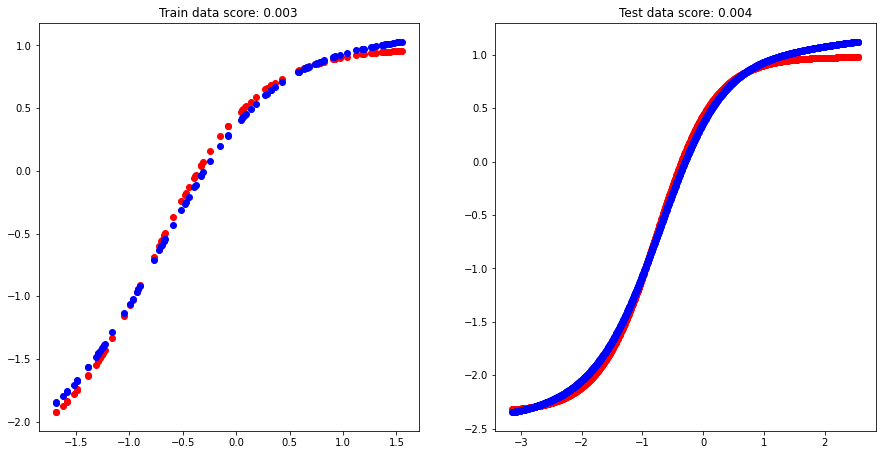

In [189]:
best=df[df["dataset"]=="activation"][-36:].nsmallest(1, 'score_test')["model_n"].values[0]
mlp_test=networks[best-1]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure(figsize=(15,7.5))
ax=fig.add_subplot(121)
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
ax.set(title='Train data score: ' +str(round(MSE(train_output_layer,output_layer)/output_layer.shape[0],3)))

output_layer=mlp_test.calculate(test_input_layer)

ax1=fig.add_subplot(122)
ax1.scatter(test_input_layer, test_output_layer, color='r')
ax1.scatter(test_input_layer,output_layer,color="b")
ax1.set(title='Test data score: ' +str(round(MSE(test_output_layer,output_layer)/output_layer.shape[0],3)))

# Cube

In [190]:
test = np.loadtxt("Project 1 datasets/regression/data.cube.train.100.csv", delimiter=',', skiprows=1, usecols=range(0,2))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=(Y-np.mean(Y,axis=0))/np.std(Y,axis=0)

In [191]:
test = np.loadtxt("Project 1 datasets/regression/data.cube.test.100.csv", delimiter=',', skiprows=1, usecols=range(0,2))
X1=test[:,0:1]
Y1=test[:,1:2]
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=(Y1-np.mean(Y,axis=0))/np.std(Y,axis=0)

## visualize

[Text(0.5, 1.0, 'Test Set')]

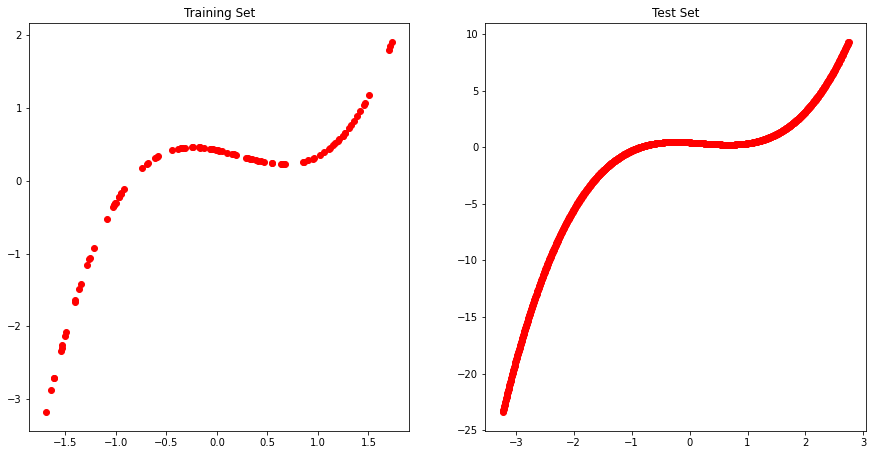

In [192]:
fig=plt.figure(figsize=(15,7.5))
ax1=fig.add_subplot(121)
ax1.scatter(train_input_layer, train_output_layer, color='r')
ax1.set(title="Training Set")
ax2=fig.add_subplot(122)
ax2.scatter(test_input_layer, test_output_layer, color='r')
ax2.set(title="Test Set")

# Calculate everything

In [193]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"cube",1,1,L,sigmoid,"sigmoid",sigmoid_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"cube",1,1,L,ReLU,"ReLU",ReLU_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"cube",1,1,L,tanh,"tanh",tanh_grad,MSE,"MSE",MSE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"cube",1,1,L,sigmoid,"sigmoid",sigmoid_grad,MAE,"MAE",MAE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"cube",1,1,L,ReLU,"ReLU",ReLU_grad,MAE,"MAE",MAE_grad,networks,networks_err,problem="regression")
    df=Generate_network_scores(df,train_input_layer,train_output_layer,test_input_layer,test_output_layer,"cube",1,1,L,tanh,"tanh",tanh_grad,MAE,"MAE",MAE_grad,networks,networks_err,problem="regression")

start error 154.9845584702919
end in epoch 300 with error 35.28928918150992
start error 191.68870782685207
end in epoch 300 with error 7.720733660600115
start error 256.9122866877803
end in epoch 300 with error 21.060414503941544
start error 75.00588634659937
end in epoch 283 with error 44.96022452817819
start error 97.9315552472819
end in epoch 300 with error 12.356254428233276
start error 124.04988926035908
end in epoch 300 with error 38.090795652432185
start error 139.7034965490047
end in epoch 300 with error 36.59132902076081
start error 63.527239672129696
end in epoch 300 with error 6.227459503319334
start error 56.94445743606063
end in epoch 300 with error 8.829404677092288
start error 108.59610013492525
end in epoch 300 with error 45.97194362887513
start error 64.19997474252851
end in epoch 300 with error 13.175068388207084
start error 50.70540453297403
end in epoch 300 with error 17.27512874271726
start error 238.04841835061038
end in epoch 300 with error 34.72292796635817
star

[Text(0.5, 1.0, 'Test data score: 16.141')]

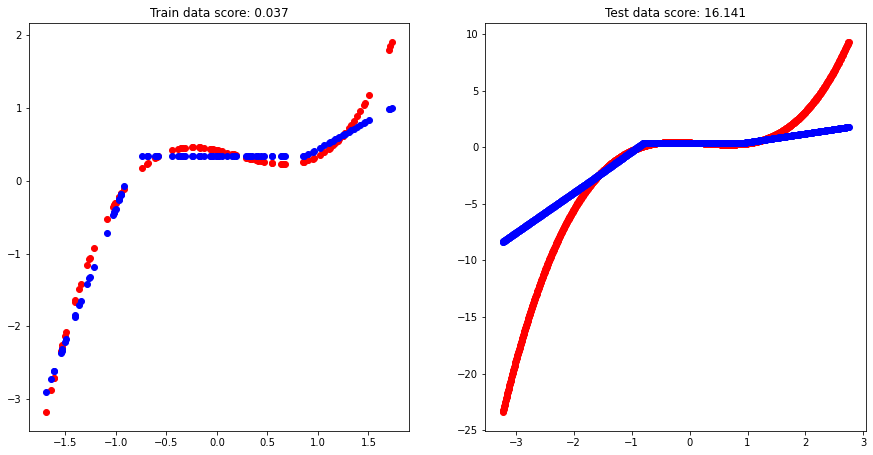

In [194]:
best=df[df["dataset"]=="cube"][-36:].nsmallest(1, 'score_test')["model_n"].values[0]
mlp_test=networks[best-1]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure(figsize=(15,7.5))
ax=fig.add_subplot(121)
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
ax.set(title='Train data score: ' +str(round(MSE(train_output_layer,output_layer)/output_layer.shape[0],3)))

output_layer=mlp_test.calculate(test_input_layer)

ax1=fig.add_subplot(122)
ax1.scatter(test_input_layer, test_output_layer, color='r')
ax1.scatter(test_input_layer,output_layer,color="b")
ax1.set(title='Test data score: ' +str(round(MSE(test_output_layer,output_layer)/output_layer.shape[0],3)))

# Results

In [195]:
df_c=df[df["problem"]=="classification"]

In [196]:
df_r=df[df["problem"]!="classification"]

## Wykres wyniku od liczby wag

### MSE

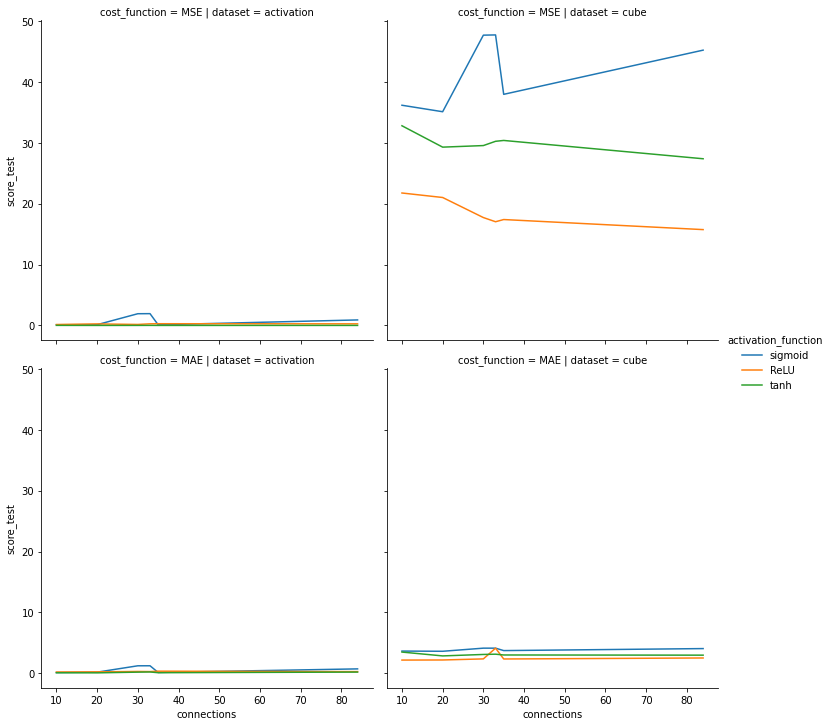

In [216]:
sns.relplot(x="connections",y="score_test",col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_r)

### Accuracy

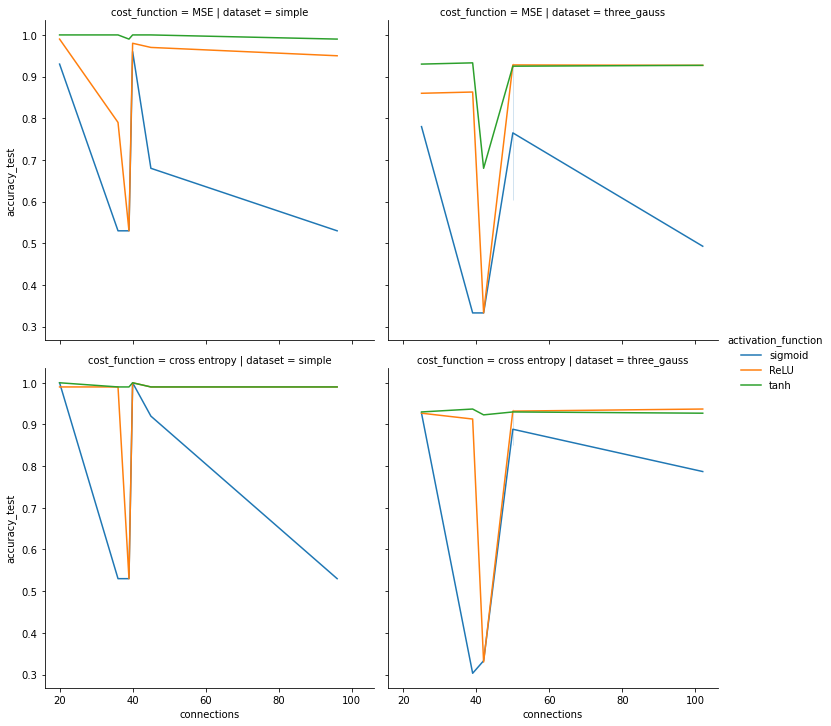

In [215]:
sns.relplot(x="connections",y="accuracy_test",col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_c)

### Entropy

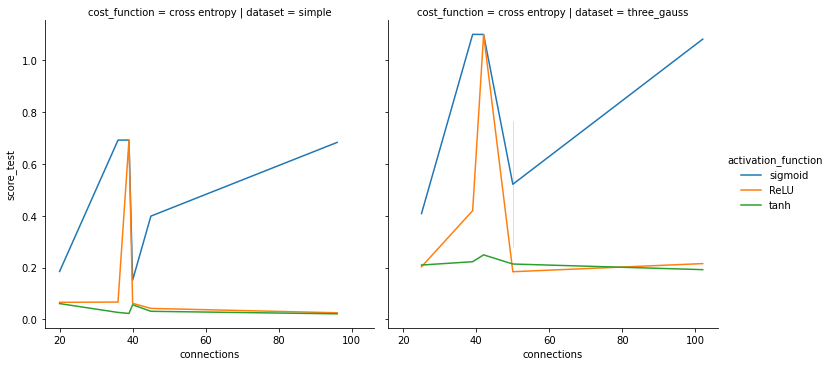

In [217]:
sns.relplot(x="connections",y="score_test",col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_c[df_c.cost_function=="cross entropy"])

Ogólnie to mamy obserwację odstającą jest to architektura [3,3,3,3] najwyrażniej architektura która jest długa, ale wąska jest złą architekturą. Po za tym to ilość wag nie ma wpływu tu oczywistego wpływu

## Wykres wyniku od liczby warstw

### MSE

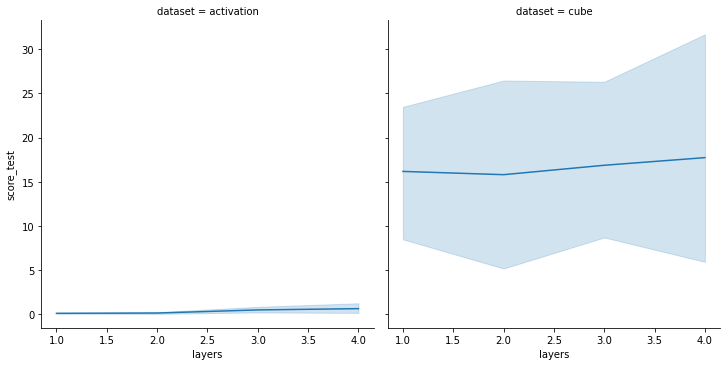

In [200]:
sns.relplot(x="layers",y="score_test",,col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_r)

### Accuracy

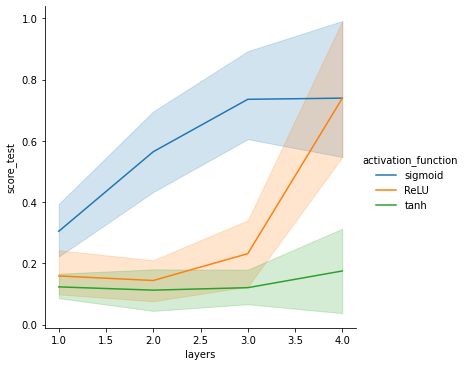

In [201]:
sns.relplot(x="layers",y="score_test",col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_c)

### Entropy

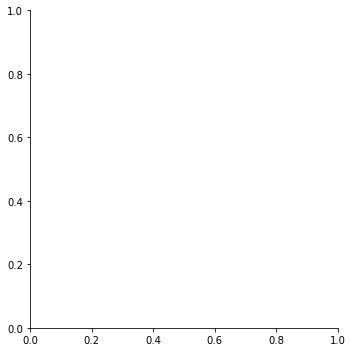

In [202]:
sns.relplot(x="layers",y="score_test",col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_c[df_c.cost_function=="Entropy"])

Ponownie architektura [3,3,3,3] jest złą architekturą. Po za tym to ilość warstw wydaje się mieć ujemny wpływ tzn im więcej warstw tym gorzej

## Wykres wyniku od liczby neuronów

### MSE

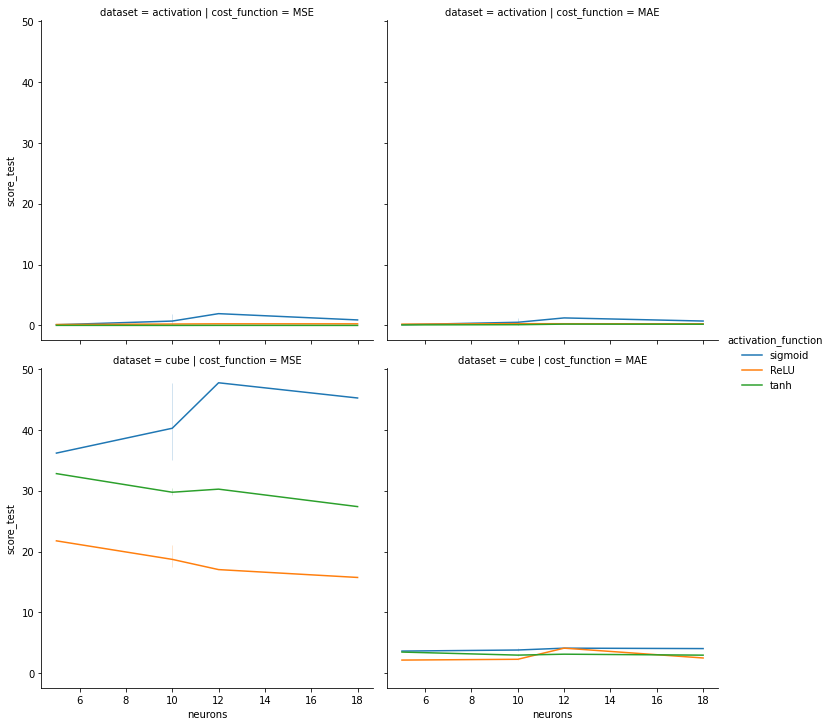

In [219]:
sns.relplot(x="neurons",y="score_test",row="dataset",col="cost_function",hue="activation_function",kind="line",data=df_r)

### Accuracy

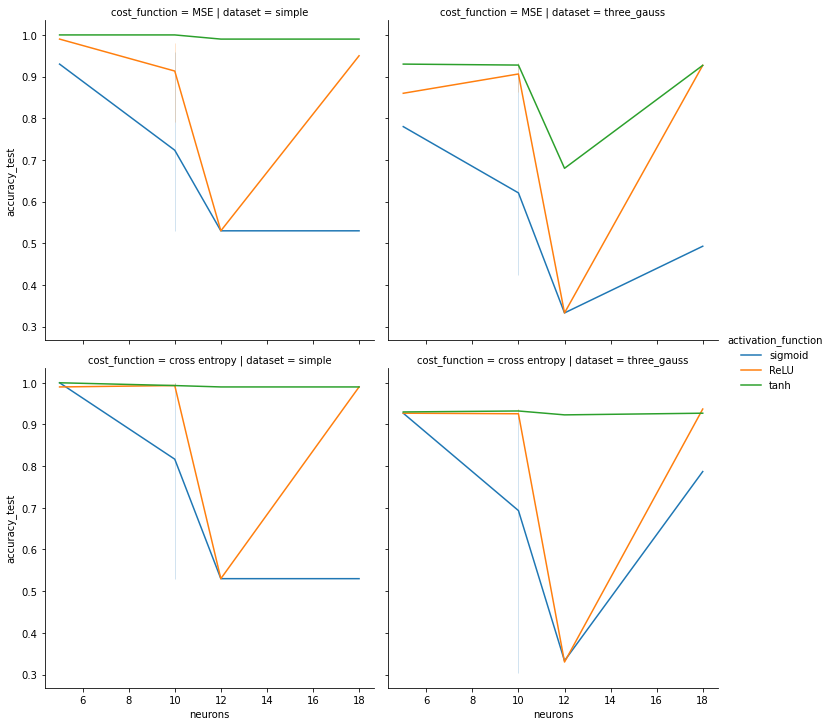

In [221]:
sns.relplot(x="neurons",y="accuracy_test",col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_c)

### Entropy

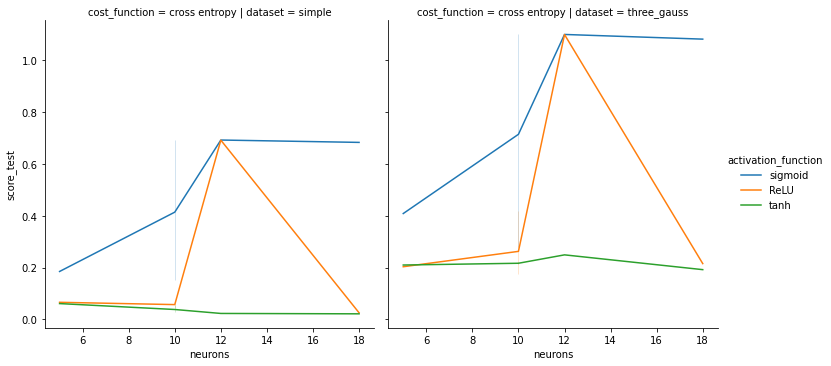

In [223]:
sns.relplot(x="neurons",y="score_test",col="dataset",row="cost_function",hue="activation_function",kind="line",data=df_c[df_c.cost_function=="cross entropy"])

Ponownie [3,3,3,3] jest słaba, ale co ciekawe [10] daję lepszę wyniki niż [5,5] oraz [3,4,3]. Możliwe że szerokość sieci jest ważna.

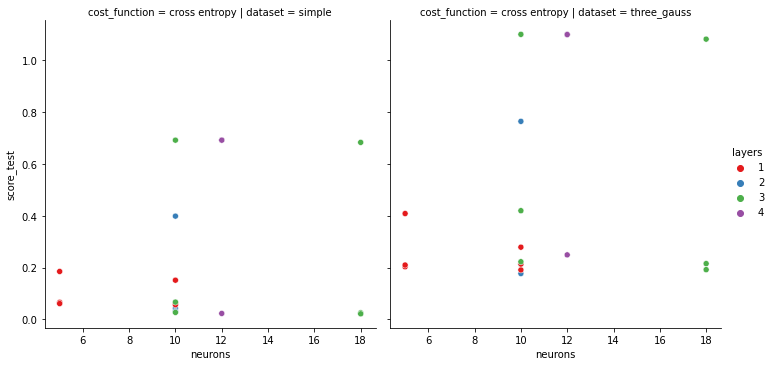

In [225]:
sns.relplot(x="neurons",y="score_test",col="dataset",row="cost_function",kind="scatter",hue="layers",data=df_c[df_c.cost_function=="cross entropy"],palette=sns.color_palette("Set1", df_r.layers.nunique()))

## Wykres czasu od liczby neuronów i warstw

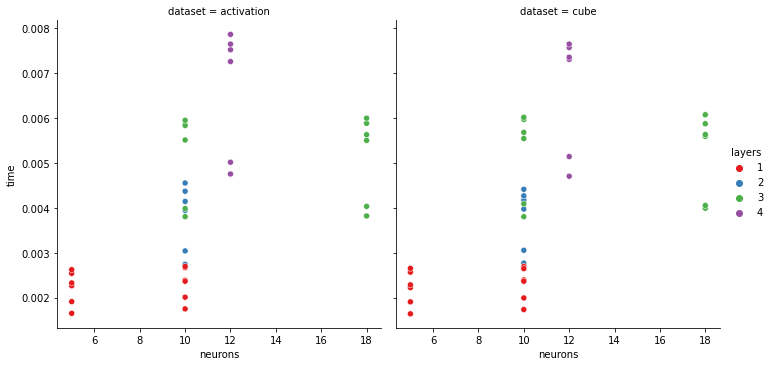

In [207]:
sns.relplot(x="neurons",y="time",col="dataset",hue="layers",kind="scatter",data=df[df.problem!="classification"],palette=sns.color_palette("Set1", df_r.layers.nunique()))

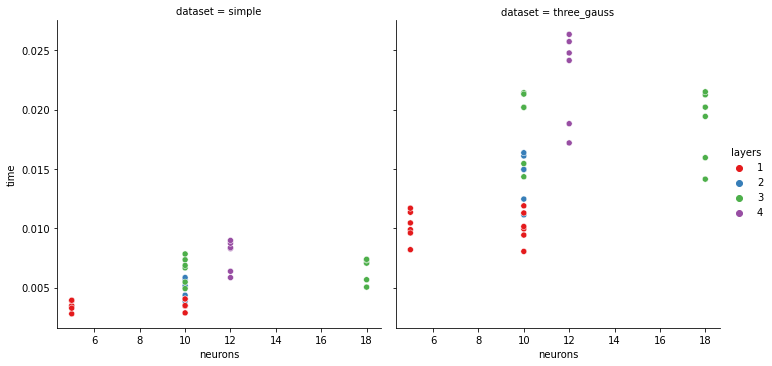

In [208]:
sns.relplot(x="neurons",y="time",col="dataset",hue="layers",kind="scatter",data=df[df.problem=="classification"],palette=sns.color_palette("Set1", df_r.layers.nunique()))

## Wykres czasu od liczby wag i warstw

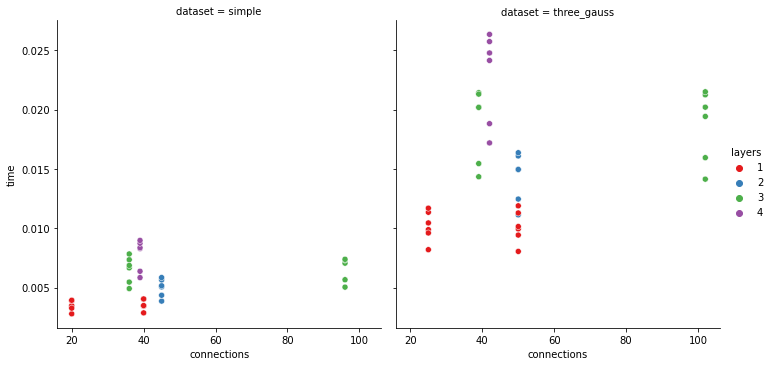

In [209]:
sns.relplot(x="connections",y="time",col="dataset",kind="scatter",hue="layers",data=df[df.problem=="classification"],palette=sns.color_palette("Set1", df_r.layers.nunique()))

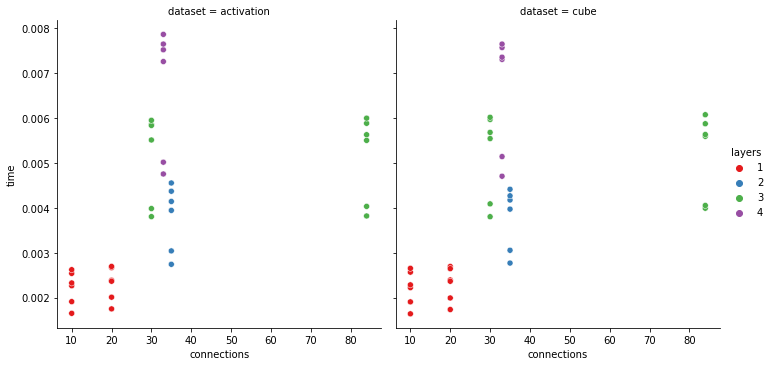

In [210]:
sns.relplot(x="connections",y="time",col="dataset",kind="scatter",hue="layers",data=df[df.problem!="classification"],palette=sns.color_palette("Set1", df_r.layers.nunique()))

## Wykres czasu od liczby warstw

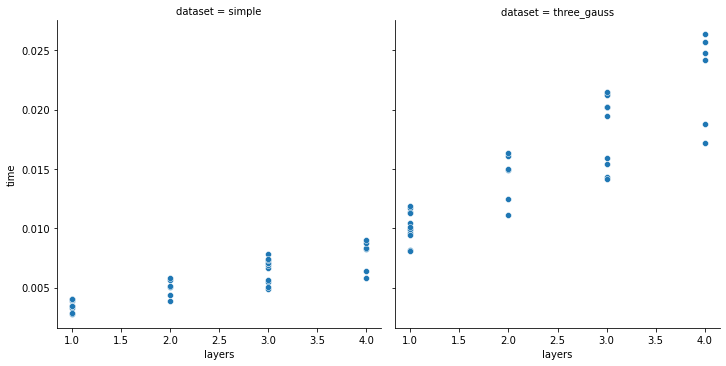

In [211]:
sns.relplot(x="layers",y="time",col="dataset",kind="scatter",data=df[df.problem=="classification"])

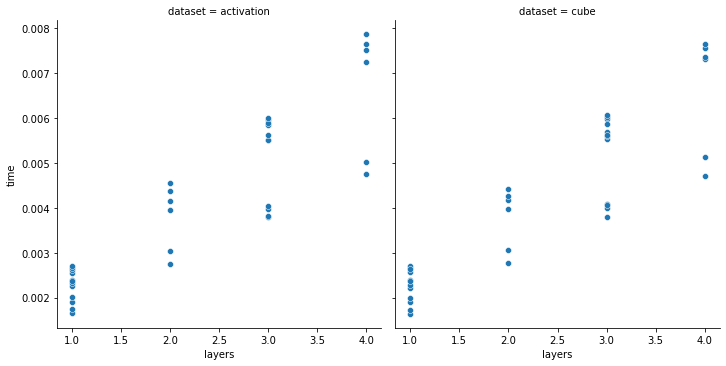

In [212]:
sns.relplot(x="layers",y="time",col="dataset",kind="scatter",data=df[df.problem!="classification"])

## errors simple in progress

In [238]:
df[df.dataset=="simple"].loc[2,"activation_function"]

'tanh'

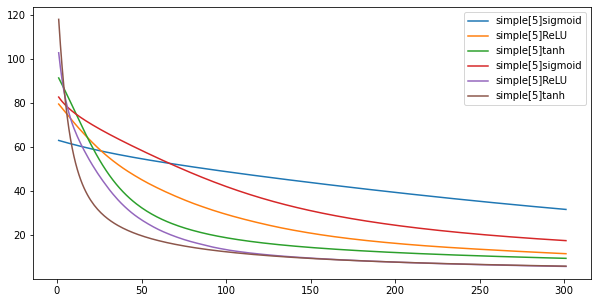

In [239]:
plt.figure(figsize=(10,5))
for x in range(0,6):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t,networks_err[x],label=networks_names[x]+df[df.dataset=="simple"].loc[x,"activation_function"])
    
plt.legend(loc="upper right")  

# Network visualization

In [251]:
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import matplotlib.lines as lin
import seaborn as sns
import matplotlib.cm as cm

In [252]:
def center(i):
    return np.linspace(0,1,i+1)[:-1].mean()

In [275]:
grad[0][w][0][r][l]

array([[-0.01336215,  0.00397878],
       [ 0.01030528, -0.00826382],
       [-0.00803942,  0.00706671],
       [-0.01060975, -0.01588994],
       [-0.01978774, -0.0075399 ],
       [ 0.00402762, -0.01806577],
       [-0.00096729,  0.01775177],
       [ 0.01659172,  0.00747251],
       [ 0.01689288,  0.02082886],
       [-0.01355261, -0.00341127]])

start error 142.50971529847715
end in epoch 1 with error 142.50971529847715


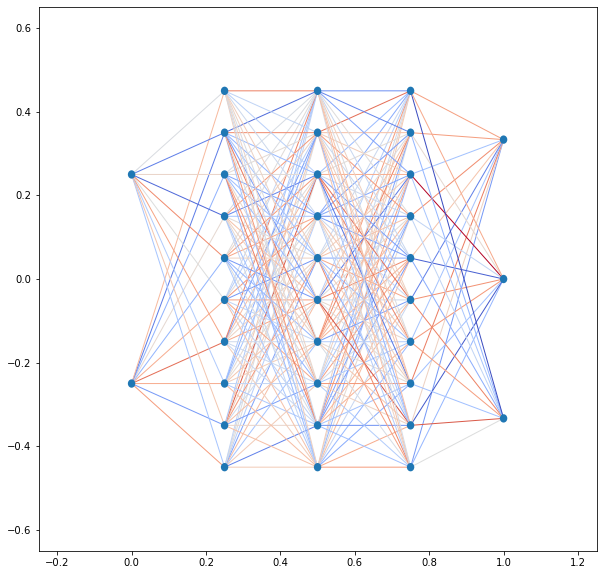

In [277]:
inpu=mlp_test.input_layer
input_len=inpu.shape[1]
output=mlp_test.output_layer
output_len=output.shape[1]
hidden=mlp_test.hidden_layers
hidden_len=[x.shape[0] for x in hidden]
weights=mlp_test.weights
grad=mlp_test.train(train_input_layer,train_output_layer,max_epoch=1,Verbose=False,rate=0,return_error_list=False,return_gradients=True)

fig,ax = plt.subplots(1,figsize=(10, 10))
ax.set_xlim(-0.25, 1.25)
ax.set_ylim(-0.65, 0.65)
ma=max([w.max() for w in weights])
mi=min([w.min() for w in weights])

cmap = cm.coolwarm
norm = Normalize(vmin=mi, vmax=ma)
#grad[0][w][0][r][l]
for w in range(len(weights)):
    for l in range(weights[w].shape[1]):
        for r in range(weights[w].shape[0]):
            ax.add_patch(pt.ConnectionPatch([w/len(weights),l/weights[w].shape[1]-center(weights[w].shape[1])],[(w+1)/len(weights),r/weights[w].shape[0]-center(weights[w].shape[0])],coordsA="data",coordsB="data",color=cmap(norm(weights[w][r,l])),lw=1))
            

for i in range(input_len):
    ax.add_patch(pt.Circle((0,i/input_len-center(input_len)),0.01))

for j in range(len(hidden_len)):
    for k in range(hidden_len[j]):
        ax.add_patch(pt.Circle(((1+j)/(len(hidden_len)+1),k/hidden_len[j]-center(hidden_len[j])),0.01))
        
for i in range(output_len):
    ax.add_patch(pt.Circle((1,i/output_len-center(output_len)),0.01))